## Homework 04
  
The [Conversation AI](https://conversationai.github.io/) team, a research initiative founded by [Jigsaw](https://jigsaw.google.com/) and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion).   
  
In 2019, Kaggle hosted their [second competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge#description) on this research. The challenge was to create a model that is capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. The competitions used a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

We shall be using this dataset to benchmark a number of ML models. While the focus of the current competition is to mitigate bias, we will not be using the metric used in the competition. Instead we will be focusing on a simpler metric [Area under the Curve (or AUC)](https://www.kaggle.com/learn-forum/53782) which is suitable to unbalanced binary datasets. Also, we shall not consider different levels of Toxicity; we shall purely take anything marked over the 0.5 level in the measured toxicity range as toxic, and anything underneath as non-toxic. 

We have created a jupyter notbook with some of the tools to model this problem in Deep Learning, using Logistic regression and MLP. Your challenge will be to fill in the models and benchmark the AUC you achieve on these models.

We shall be using the keras deep learning package. As you may know, this is an API into DL frameworks, but is most commonly backed by Tensorflow. [keras.io](keras.io) is a great source for documentation and examples on layers available andn functionality. 

**Have fun!!**


*Disclaimer: the dataset used contains text that may be considered profane, vulgar, or offensive.*

### Set up packages

In [1]:
!/usr/bin/yes | pip uninstall keras
!pip install keras==2.2.5

Uninstalling Keras-2.3.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.3.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
Proceed (y/n)?   Successfully uninstalled Keras-2.3.1
/usr/bin/yes: standard output: Broken pipe
     |################################| 337kB 2.1MB/s eta 0:00:01
     |################################| 51kB 581kB/s  eta 0:00:01
  Found existing installation: Keras-Preprocessing 1.0.5
    Uninstalling Keras-Preprocessing-1.0.5:
      Successfully uninstalled Keras-Preprocessing-1.0.5
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os
import time
import tensorflow as tf
import keras
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import pandas as pd
import numpy as np
import scipy

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA Tegra X2, pci bus id: 0000:00:00.0, compute capability: 6.2



In [2]:
keras.__version__

'2.2.5'

### Load data
Let's load our data and take a peak.   
The competition metrics and fields have too much detail too cover here.   
We will just focus on the comment of the users and whether it was deemed toxic (target>0.5) or not.    

In [3]:
# Lets look at what files we have available. 
os.listdir()

['X_val_mat.npz',
 'train.csv.zip',
 'X_trn_mat.npz',
 'w251_homework04.ipynb',
 'docker',
 'README.md',
 '.ipynb_checkpoints']

In [4]:
train_df = pd.read_csv('train.csv.zip', 
                       dtype={'comment_text':str},
                       usecols=['comment_text', 'target'],
                       compression = 'zip')
train_df['target'] = (train_df['target']>0.5).astype(int)
print("Dataframe Number of (rows, columns) : {}".format(train_df.shape))

Dataframe Number of (rows, columns) : (1804874, 2)


In [5]:
pd.options.display.max_colwidth = 200
train_df.head(10)

,target,comment_text
0,0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!"
1,0,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"
2,0,This is such an urgent design problem; kudos to you for taking it on. Very impressive!
3,0,Is this something I'll be able to install on my site? When will you be releasing it?
4,1,haha you guys are a bunch of losers.
5,1,ur a sh*tty comment.
6,0,hahahahahahahahhha suck it.
7,0,FFFFUUUUUUUUUUUUUUU
8,0,The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.
9,0,It was a great show. Not a combo I'd of expected to be good together but it was.


### Create validation data set
Lets randomly 66/33 split the data into a training and validation set.   
**No change needed here - note, please do not change the KFold split parameters, keeping it consistent will help us debug.**

In [6]:
cv = KFold(n_splits=3, shuffle=True, random_state=42)
trn_ids, val_ids = next(cv.split(train_df))
x_train, x_valid = train_df['comment_text'][trn_ids], train_df['comment_text'][val_ids]
y_train, y_valid = train_df['target'].values[trn_ids], train_df['target'].values[val_ids]

### Vectorize Count of tokens

![Count Vectorizer](https://cdn-images-1.medium.com/max/1600/1*LD5XaHzOnoniU4p137FL5g.jpeg)  
We shall start off performing some CPU based Deep Learning operations. Sparse matrices are better run on CPU.    
Do not underestimate CPU based Deep Learning such as MLP; these models can be very powerful and outperform complex much more complex DL models.   
Here we create a sparse matrix from the text with 200K of the most common unigram and bigrams.  
**Your task here is to convert the collection of text documents (found in the `comment_text` field) to a matrix of token counts.  
This can be done using the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) in scikit_learn.  
After creating the vectorizer, fit it based on the train matrix `x_train` and use this vectorizer to transform both the `x_train` and `x_valid` sets.   
Create sparse matrices called `X_trn_mat` and `X_val_mat`, and please call your vectorizer: `vectorizer`.  
Use the parameters max features = 200000 and the token pattern `\w+`. This token pattern matches one or more word characters (same as `[a-zA-Z0-9_]`) only. All other characters are stripped.
Also, we would like to count both unigrams and bigrams (pairs of words), so set the ngram range to `(1,2)`**

In [7]:
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Create a CountVectorizer, called `vectorizer`
# And create sparse matrices X_trn_mat & X_val_mat
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Define vectorizer parameters
max_features=200000
token_pattern='\w+'
ngram_range=(1,2)

# Define a vectorizer class object
vectorizer = CountVectorizer(
                max_features=max_features,
                token_pattern=token_pattern,
                ngram_range=ngram_range)

# Fit the vectorizer on the training dataset
vectorizer.fit(x_train)

# Create the term document matrix for training and validation datasets
if os.path.isfile('./X_trn_mat.npz'): 
    X_trn_mat = scipy.sparse.load_npz('./X_trn_mat.npz')
else:
    X_trn_mat = vectorizer.transform(x_train)
    scipy.sparse.save_npz('./X_trn_mat.npz',X_trn_mat)
if os.path.isfile('./X_val_mat.npz'):
    X_val_mat = scipy.sparse.load_npz('./X_val_mat.npz')             
else:
    X_val_mat = vectorizer.transform(x_valid)
    scipy.sparse.save_npz('./X_val_mat.npz',X_val_mat)


In [8]:
print(vectorizer.get_feature_names()[:10])
print(vectorizer.get_feature_names()[100000:100000+10])

['0', '0 0', '0 00', '0 01', '0 05', '0 1', '0 2', '0 25', '0 3', '0 4']
['make more', 'make most', 'make much', 'make my', 'make new', 'make no', 'make noise', 'make obama', 'make of', 'make on']


### Logistic Regression

![Logistic Regression](https://upload.wikimedia.org/wikipedia/commons/6/6d/Exam_pass_logistic_curve.jpeg)
  
Lets start off with a simple Logistic Regression, which is the very basic [sigmoid activation function](https://en.wikipedia.org/wiki/Sigmoid_function) used in DL.  
Notice we have no hidden layers, we take as input the whole sparse matrix, and as output the binary classifier prediction (`0<=output<=1`).  
The model has 200001 parameters. One coefficient per column in the sparse matrx, plus one bias variable - each of which is learned using gradient descent. 


In [9]:
model_in = keras.Input(shape=(X_trn_mat.shape[1],), dtype='float32',sparse=True)
out = keras.layers.Dense(1, activation='sigmoid')(model_in)
model = keras.Model(inputs=model_in, outputs=out)
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-2))
model.summary()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 200001    
Total params: 200,001
Trainable params: 200,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time 
start = time.time()
model.fit(X_trn_mat, y_train, epochs=2, batch_size=2**13, validation_data=(X_val_mat, y_valid))
print(time.time()-start)



Train on 1203249 samples, validate on 601625 samples
Epoch 1/2





In [11]:
preds_lr = model.predict(X_val_mat).flatten()
print('AUC score : {:.5f}'.format(roc_auc_score(y_valid, preds_lr)))

AUC score : 0.88526


### Look at the coefficients to see which words are driving toxic and non-toxic sentences. 

In [ ]:
feats = np.array(vectorizer.get_feature_names())
importance_index = model.get_weights()[0].flatten().argsort()
print('Top toxic tokens : \n{}'.format(feats[importance_index[-10:]].tolist()))
print('\nTop non-toxic tokens : \n{}'.format(feats[importance_index[:10]].tolist()))

### MLP

![MLP](https://www.researchgate.net/profile/Mouhammd_Alkasassbeh/publication/309592737/figure/fig2/AS:423712664100865@1478032379613/MultiLayer-Perceptron-MLP-sturcture-334-MultiLayer-Perceptron-Classifier-MultiLayer.png)

Here we shall create a Multi-layer perceptron. Although relatively simple, these can be very powerful models and also suited to low compute power. 
**Please add three hidden layers to the network using a `relu` activation function.  
You can refer to this [script](https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s). This script contains an MLP which took first place in the *Mercari Price Suggestion Challenge*.   
Note, you can do this task by only adding four lines of code. You should see a large increase in AUC over the Logistic Regression.**  
Never underestimate the power of an MLP!!

In [8]:
model_in = keras.Input(shape=(X_trn_mat.shape[1],), dtype='float32', sparse=True,name="input")
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Please fill in the next lines with the three hidden layers and the output layer. 
h1_dim = 192
h2_dim = 64
h3_dim = 64
out_dim = 1 # binary classification
h1 = keras.layers.Dense(h1_dim,activation='relu',name="hidden1")(model_in)
h2 = keras.layers.Dense(h2_dim,activation='relu',name="hidden2")(h1)
h3 = keras.layers.Dense(h3_dim,activation='relu',name="hidden3")(h2)
out = keras.layers.Dense(out_dim,activation='sigmoid',name="output")(h3)
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
model = keras.Model(inputs=model_in, outputs=out)
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-3))
model.summary()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 200000)            0         
_________________________________________________________________
hidden1 (Dense)              (None, 192)               38400192  
_________________________________________________________________
hidden2 (Dense)              (None, 64)                12352     
_________________________________________________________________
hidden3 (Dense)              (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 38,416,769
Trainable params: 38,416,769
Non-trainable params: 0
_________________________________________________________________


In [9]:
import time
start = time.time()
model.fit(X_trn_mat, y_train, batch_size=2**13, epochs=2, verbose=1, validation_data=(X_val_mat, y_valid))
preds_mlp = model.predict(X_val_mat).flatten()
print(time.time()-start)



Train on 1203249 samples, validate on 601625 samples
Epoch 1/2




1203249/1203249 [==============================] - 585s 486us/step - loss: 0.2136 - val_loss: 0.1219
Epoch 2/2
1203249/1203249 [==============================] - 609s 506us/step - loss: 0.0831 - val_loss: 0.1229
1419.565755367279


In [10]:
print('AUC score : {:.5f}'.format(roc_auc_score(y_valid, preds_mlp)))

AUC score : 0.93273


### MLP with regularisation

Now lets try regularization.  
**Copy the above MLP model and create a new one adding regularization into the MLP hidden layers.  
    Add l2 regularisation to each of the dense hidden layers. Check on [keras.io](https://keras.io) to find details on how to add l2 regularization. Play are around with different level of regularization to see when you achieve optimal results.   
Generally it is good to choose parameters like regularization by moving up and down in factors of `10`.  
Can you improve on your previous AUC results by using reglarisation?**

In [11]:
## Adding Regularization
import matplotlib.pyplot as plt
def kerasModelReg(h1_dim,h2_dim,h3_dim,reg_param=0.1):

    # Build the model
    model_in = keras.Input(shape=(X_trn_mat.shape[1],), dtype='float32', sparse=True,name="input")
    out_dim = 1 # binary classification
    h1 = keras.layers.Dense(h1_dim,activation='relu',name="hidden1",
                            kernel_regularizer=keras.regularizers.l2(reg_param))(model_in)
    h2 = keras.layers.Dense(h2_dim,activation='relu',name="hidden2",
                           kernel_regularizer=keras.regularizers.l2(reg_param))(h1)
    h3 = keras.layers.Dense(h3_dim,activation='relu',name="hidden3",
                           kernel_regularizer=keras.regularizers.l2(reg_param))(h2)
    out = keras.layers.Dense(out_dim,activation='sigmoid',name="output")(h3)
    model = keras.Model(inputs=model_in, outputs=out)
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-3))
    return model

# Main
roc_auc_scores = []
train_losses = []
val_losses = []
epochs = 2
h1_dim = 192
h2_dim = 64
h3_dim = 64
reg_params = [1e-6,1e-4,0.001,0.01,0.1]

for reg_param in reg_params:
    keras.backend.clear_session()
    model = kerasModelReg(h1_dim,h2_dim,h3_dim,reg_param)
    print("-----Reg Param = %f------" %(reg_param))
    model.fit(X_trn_mat, y_train, batch_size=2**13, epochs=epochs, verbose=1, validation_data=(X_val_mat, y_valid))
    preds_mlp = model.predict(X_val_mat).flatten()
    
    # Save the performance metrics
    train_losses.append(model.history.history['loss'])
    val_losses.append(model.history.history['val_loss'])
    roc_auc_scores.append(roc_auc_score(y_valid, preds_mlp))











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
-----Reg Param = 0.000001------


Train on 1203249 samples, validate on 601625 samples
Epoch 1/2




1203249/1203249 [==============================] - 121s 101us/step - loss: 0.2078 - val_loss: 0.1249
Epoch 2/2
1203249/1203249 [==============================] - 88s 73us/step - loss: 0.0888 - val_loss: 0.1283
-----Reg Param = 0.000100------
Train on 1203249 samples, validate on 601625 samples
Epoch 1/2
1203249/1203249 [==============================] - 103s 85us/step - loss: 0.2282 - val_loss: 0.1621
Epoch 2/2
1203249/1203249 [==============================] - 86s 71us/step - loss: 0.1464 - val_loss: 0.1511
-----Reg Param = 0.001000------
Train on 1203249 samples, validate on 601625 samples
Epoch 1/2
1203249/1203249 [==============================] - 103s 85us/step - loss: 0.3392 - val_loss: 0.2276
Epoch 2/2
1203249/1203249 [==============================] - 84s 70us/step - loss: 0.21

In [ ]:
train_losses_final = [x[1] for x in train_losses]
val_losses_final = [x[1] for x in val_losses]

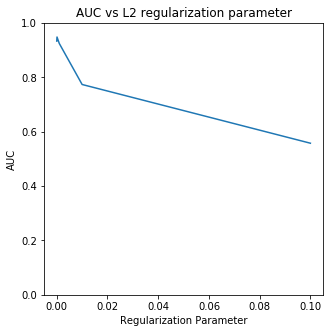

In [63]:
# Plot the AUC scores versus regularizaton parameters 
fig = plt.figure(0,figsize=(5,5))
plt.plot(reg_params,roc_auc_scores)
plt.ylim(0,1)
plt.xlabel("Regularization Parameter")
plt.ylabel("AUC")
plt.title("AUC vs L2 regularization parameter")
plt.show()

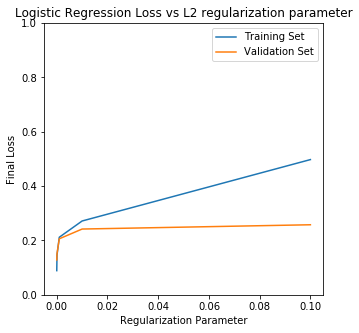

In [61]:
fig = plt.figure(1,figsize=(5,5))
plt.plot(reg_params,train_losses_final,label="Training Set")
plt.plot(reg_params,val_losses_final,label="Validation Set")
plt.ylim(0,1)
plt.xlabel("Regularization Parameter")
plt.ylabel("Final Loss")
plt.legend()
plt.title("Logistic Regression Loss vs L2 regularization parameter")
plt.show()